In [1]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

rand = np.random.randint(0, 1000000)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [3]:
def createfeatures(data,cat_feature):
    list=['NoEmp','CreateJob','RetainedJob','DisbursementGross','GrAppv','SBA_Appv']
    
    for col in list:
        means = data.groupby(cat_feature)[col].mean()
        # 各ローンのTermとセクター平均Termとの差を計算
        data[f'{col}_Diff_{cat_feature}_Mean'] = data.apply(lambda x: x[col] - means[x[cat_feature]], axis=1)

        # 各ローンのTermとセクター平均Termとの比を計算
        data[f'{col}_Ratio_{cat_feature}_Mean'] = data.apply(lambda x: x[col] / means[x[cat_feature]], axis=1)
        
    return data

In [4]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [5]:
data

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train,DisbursementYear,DisbursementMonth,DisbursementDay,ApprovalYear,ApprovalMonth,ApprovalDay,IsSameState,LoanProcessingPeriod,LoanvsApprovedAmountDifference,SBAGuaranteeRatio,YearsSinceApproval,FranchiseFlag,Jobs_Created_per_Employee,Jobs_Retained_per_Employee,Loan_Amount_per_Employee,BankStateCount,CityCount,SectorCount,StateCount
0,0,163,21,1.0,0,0,1,N,N,1,0,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,True,1998.0,1.0,31.0,2006,9,22,False,-3156.0,0.0,0.85,18,NaN,0.000000,0.000000,3.809524e+03,4667,628,19619,1524
1,1,84,6,1.0,4,0,0,0,N,1,62,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,True,1993.0,10.0,31.0,1992,6,30,True,488.0,0.0,0.80,32,NaN,0.666667,0.000000,4.783333e+04,912,22,2354,1083
2,2,242,45,1.0,4,90,0,N,N,1,42,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,True,2001.0,8.0,31.0,2001,4,18,True,135.0,-1983.0,0.50,23,NaN,0.088889,2.000000,7.107333e+02,353,15,14841,906
3,3,237,4,1.0,0,0,0,N,N,1,33,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,True,2007.0,8.0,31.0,2003,10,6,False,1425.0,0.0,1.00,20,NaN,0.000000,0.000000,5.725000e+04,4667,1230,10159,2276
4,4,184,0,1.0,0,0,0,N,N,1,0,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,True,1983.0,6.0,8.0,1999,12,17,True,-6036.0,0.0,0.75,24,NaN,NaN,NaN,inf,12967,1207,19619,13827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,84610,243,10,1.0,3,14,0,N,N,NaN,42,2012,FT. WRIGHT,KY,OH,390000.0,150000.0,127500.0,0,False,2012.0,12.0,1.0,2012,4,23,False,222.0,-240000.0,0.85,12,NaN,0.300000,1.400000,3.900000e+04,5663,20,14841,820
84611,84611,178,0,2.0,0,0,1,N,N,NaN,0,2007,PHILADELPHIA,PA,RI,100000.0,100000.0,90000.0,0,False,2003.0,11.0,30.0,2006,10,27,False,-1062.0,0.0,0.90,17,NaN,NaN,NaN,inf,5127,1146,19619,5580
84612,84612,42,1,2.0,3,9,0,Y,N,NaN,33,1989,ELMHURST,IL,IL,17000.0,17000.0,13600.0,0,False,2009.0,2.0,28.0,1989,9,21,True,7100.0,0.0,0.80,35,NaN,3.000000,9.000000,1.700000e+04,5891,26,10159,1950
84613,84613,76,15,1.0,0,0,0,N,N,NaN,0,2006,NASHVILLE,TN,TN,7500.0,7500.0,6375.0,0,False,2008.0,1.0,31.0,2006,4,3,True,668.0,0.0,0.85,18,NaN,0.000000,0.000000,5.000000e+02,1354,1230,19619,2276


In [370]:
# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [371]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

# Calculate the distance between State and BankState
data['State_BankState_Distance'] = data.apply(lambda x: haversine(x['Latitude'], x['Longitude'], 
                                                                   x['BankState_Latitude'], x['BankState_Longitude']) 
                                              if pd.notnull(x['Latitude']) and pd.notnull(x['BankState_Latitude']) 
                                              else None, axis=1)

In [372]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [373]:
# 訓練データの読み込み
X_train = train[['Term']]

# スケーラーの初期化と適用（訓練データに対して）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X_train_scaled)
    bics.append(gmm.bic(X_train_scaled))

# クラスタ数を選定
gmm = GaussianMixture(n_components=9, random_state=0)
gmm.fit(X_train_scaled)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X_train_scaled)

# クラスタ割り当て結果をデータフレームに追加
train['Term_Cluster'] = cluster_assignments

# テストデータの読み込みとスケーリング（訓練データでフィットしたスケーラーを使用）
X_test = test[['Term']]
X_test_scaled = scaler.transform(X_test)

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test_scaled)

In [374]:
# for col in ['State','Sector','FranchiseCode','Term_Cluster']:
#     train = createfeatures(train,col)
#     test = createfeatures(test,col)

In [375]:
category_features = ['State','BankState', 'Sector',  'NewExist','UrbanRural','RevLineCr', 'LowDoc','IsSameState','Term_Cluster']

In [376]:
num_cols = ['Term','NoEmp','CreateJob','RetainedJob','DisbursementGross','GrAppv','SBA_Appv']

In [377]:
# agg_cols = ['min', 'max', 'mean', 'std']

# for col in category_features:
#     grp_df = train.groupby(col)[num_cols].agg(agg_cols)
#     grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
#     train = train.merge(grp_df, on=col, how='left')
#     test = test.merge(grp_df, on=col, how='left')  

In [378]:
train

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,DisbursementYear,DisbursementMonth,DisbursementDay,ApprovalYear,ApprovalMonth,ApprovalDay,IsSameState,LoanProcessingPeriod,LoanvsApprovedAmountDifference,SBAGuaranteeRatio,YearsSinceApproval,FranchiseFlag,Jobs_Created_per_Employee,Jobs_Retained_per_Employee,Loan_Amount_per_Employee,BankStateCount,CityCount,SectorCount,StateCount,missing_values_count,Latitude,Longitude,BankState_Latitude,BankState_Longitude,State_BankState_Distance,Term_Cluster
0,0,163,21,1.0,0,0,1,N,N,1,0,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,1998.0,1.0,31.0,2006,9,22,False,-3156.0,0.0,0.85,18,NaN,0.000000,0.000000,3809.523810,4667,628,19619,1524,1,33.729759,-111.431221,44.299782,-99.438828,1563.425413,3
1,1,84,6,1.0,4,0,0,0,N,1,62,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,1993.0,10.0,31.0,1992,6,30,True,488.0,0.0,0.80,32,NaN,0.666667,0.000000,47833.333333,912,22,2354,1083,1,35.565342,-96.928917,35.565342,-96.928917,0.000000,4
2,2,242,45,1.0,4,90,0,N,N,1,42,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,2001.0,8.0,31.0,2001,4,18,True,135.0,-1983.0,0.50,23,NaN,0.088889,2.000000,710.733333,353,15,14841,906,1,40.298904,-74.521011,40.298904,-74.521011,0.000000,1
3,3,237,4,1.0,0,0,0,N,N,1,33,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,2007.0,8.0,31.0,2003,10,6,False,1425.0,0.0,1.00,20,NaN,0.000000,0.000000,57250.000000,4667,1230,10159,2276,1,35.747845,-86.692345,44.299782,-99.438828,1439.951815,1
4,4,184,0,1.0,0,0,0,N,N,1,0,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,1983.0,6.0,8.0,1999,12,17,True,-6036.0,0.0,0.75,24,NaN,NaN,NaN,NaN,12967,1207,19619,13827,4,36.116203,-119.681564,36.116203,-119.681564,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,42302,283,14,1.0,0,0,1,N,N,1,0,1995,PHILADELPHIA,PA,PA,80000.0,80000.0,68000.0,0,1998.0,1.0,31.0,1995,3,2,True,1066.0,0.0,0.85,29,NaN,0.000000,0.000000,5714.285714,2534,1146,19619,5580,1,40.590752,-77.209755,40.590752,-77.209755,0.000000,5
42303,42303,53,2,1.0,0,0,0,Y,N,1,42,2007,LOS ANGELES,CA,SD,5000.0,5000.0,4250.0,1,1991.0,4.0,3.0,2007,6,6,False,-5908.0,0.0,0.85,17,NaN,0.000000,0.000000,2500.000000,4667,714,14841,13827,1,36.116203,-119.681564,44.299782,-99.438828,1937.621245,8
42304,42304,59,6,2.0,0,0,1,N,N,1,42,2003,COLUMBUS,OH,OH,60000.0,60000.0,51000.0,0,2003.0,2.0,28.0,2003,3,14,True,-14.0,0.0,0.85,21,NaN,0.000000,0.000000,10000.000000,5663,254,14841,2450,1,40.388783,-82.764915,40.388783,-82.764915,0.000000,8
42305,42305,295,18,1.0,0,8,0,N,N,1,42,1989,CLOQUET,MN,MN,294000.0,294000.0,220500.0,0,1997.0,12.0,10.0,1989,8,23,True,3031.0,0.0,0.75,35,NaN,0.000000,0.444444,16333.333333,1647,7,14841,2008,1,45.694454,-93.900192,45.694454,-93.900192,0.000000,5


In [379]:
from category_encoders import CatBoostEncoder

for col in category_features:
    X = train[col]
    test_X = test[col]
    y = train['MIS_Status'].astype('int')

    encoder = CatBoostEncoder(cols=[col], a=0)

    encoder.fit(X, y)
    encoded_train = encoder.transform(X, y)
    encoded_test = encoder.transform(test_X)

    test.loc[:, f"ordered_{col}"] = encoded_test
    train.loc[:, f"ordered_{col}"] = encoded_train
    
    train = train.drop([col],axis=1)
    test = test.drop([col],axis=1)

In [380]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [381]:
from sklearn.model_selection import KFold
# クロスバリデーションの設定
n_splits = 5
kf = KFold(n_splits=n_splits)

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    
    # ここで目的変数を設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']

    X_train = X_train.drop(['MIS_Status'],axis=1)
    X_val = X_val.drop(['MIS_Status'],axis=1)
    # モデルの訓練
    model = lgb.LGBMClassifier(extra_tree=True)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]

    # テストデータに対する予測
    test_preds += model.predict_proba(test)[:, 1] / n_splits

# 訓練データにOOF予測を追加
train['lgb_preds'] = oof_preds

# テストデータに予測を追加
test['lgb_preds'] = test_preds

In [382]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'lgb_preds']]
test_csv = test[['ID', 'lgb_preds']]

# CSVファイルに保存
train_csv_path = '../data/train_lgb_predictions2.csv'
test_csv_path = '../data/test_lgb_predictions2.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

train = train.drop(['ID', 'lgb_preds'],axis=1)
test = test.drop(['ID', 'lgb_preds'],axis=1)

In [383]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = y_train.astype('int')
y_val = y_val.astype('int')


In [384]:
# def objective(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     model = lgb.LGBMClassifier(**param)
#     model.fit(X_train, y_train)
#     preds = model.predict(X_val)
#     f1 = f1_score(y_val, preds)
#     return f1

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # 最適なパラメータを表示
# print(study.best_params)

In [385]:
# from scipy.optimize import minimize

# def f1_optimizer(threshold, train_y, train_pred_prob ):
#     return -f1_score(train_y, train_pred_prob >= threshold)

# models = []
# thresholds = []

# for seed in range(10):
#     # データサンプリング
#     train_sample = X_train.sample(frac=0.8, random_state=seed)
#     y_sample = y_train[train_sample.index]

#     # モデルの学習
#     lgb_clf = lgb.LGBMClassifier()
#     lgb_clf.fit(train_sample, y_sample)

#     # 検証データに対する予測確率
#     y_pred_proba = lgb_clf.predict_proba(X_val)[:, 1]

#     result = minimize(f1_optimizer, x0 = 0.5, args = (y_val, y_pred_proba), method = "Nelder-Mead")
#     print(result)
    
#     print("最適な閾値：{}".format(result["x"].round(3)))
#     print("最適な閾値でのf1_score：{}".format(f1_score(y_val, y_pred_proba >= result["x"]).round(3)))

#     # メトリクスの計算
#     y_pred = (y_pred_proba > result["x"]).astype(int)
#     accuracy = accuracy_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     roc_auc = roc_auc_score(y_val, y_pred_proba)

#     # モデルと閾値をリストに追加
#     models.append(lgb_clf)
#     thresholds.append(result["x"])

# # 閾値の平均を計算
# average_threshold = sum(thresholds) / len(thresholds)

In [386]:

# 2. トレーニングデータのサンプルを10回取得し、それを使用してモデルを学習する。
models = []
for seed in range(10):
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]

    # モデルの学習
    lgb_clf = lgb.LGBMClassifier()
    lgb_clf.fit(train_sample, y_sample)

    # 検証データに対する予測
    y_pred = lgb_clf.predict(X_val)
    y_pred_proba = lgb_clf.predict_proba(X_val)[:, 1]  # AUCの計算に使用

    # メトリクスの計算
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # モデルをリストに追加
    models.append(lgb_clf)

In [387]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [388]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [389]:
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= 0.5)  # True positives
FP = (y_val == 0) & (y_pred >= 0.5)  # False positives
TN = (y_val == 0) & (y_pred < 0.5)  # True negatives
FN = (y_val == 1) & (y_pred < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7650943403246752
Total cases: 8462
True positives: 7467 ( 88.24 %)
False positives: 697 ( 8.24 %)
True negatives: 190 ( 2.25 %)
False negatives: 108 ( 1.28 %)


In [390]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > 0.5,1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.905, 0.915, 0.986, 0.949, 0.765


In [391]:
# 各モデルからの予測確率を集める
y_preds_proba = [model.predict_proba(test) for model in models]

# 予測確率の平均を計算する
y_proba_avg = np.mean(y_preds_proba, axis=0)

# 最も高い確率のクラスを選択する
y_new_pred = np.argmax(y_proba_avg, axis=1)


In [392]:
y_proba_avg

array([[0.64905206, 0.35094794],
       [0.04056404, 0.95943596],
       [0.36207836, 0.63792164],
       ...,
       [0.08633639, 0.91366361],
       [0.04862005, 0.95137995],
       [0.63827932, 0.36172068]])

In [393]:
# 閾値を設定（例：0.5）
threshold = 0.837

# 閾値を超える確率を持つ予測を1とし、それ以外を0とする
y_pred_threshold = (y_proba_avg[:, 1] >= threshold).astype(int)

# 0と1の割合を計算
zeros = np.sum(y_pred_threshold == 0) / len(y_pred_threshold)
ones = np.sum(y_pred_threshold == 1) / len(y_pred_threshold)

# 結果を表示
print(f"0の割合: {zeros * 100:.2f}%")
print(f"1の割合: {ones * 100:.2f}%")

0の割合: 11.18%
1の割合: 88.82%


In [394]:
y_pred_threshold

array([0, 1, 0, ..., 1, 1, 0])

In [395]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = y_pred_threshold
filename = 'lgb_base'

submit.to_csv(f'../outputs/{rand}.csv', index=False,header=None)

In [396]:
# 特徴量の重要度を取得
importance = lgb_clf.feature_importances_

# 特徴量の名前を取得
feature_names = X_train.columns

# 特徴量の重要度を降順にソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) ordered_RevLineCr              163.000000
 2) ordered_Sector                 153.000000
 3) ordered_BankState              131.000000
 4) ordered_UrbanRural             121.000000
 5) CityCount                      120.000000
 6) ordered_LowDoc                 119.000000
 7) ordered_Term_Cluster           116.000000
 8) ordered_IsSameState            115.000000
 9) Loan_Amount_per_Employee       111.000000
10) ApprovalDay                    110.000000
11) Term                           108.000000
12) ordered_NewExist               107.000000
13) ordered_State                  106.000000
14) LoanProcessingPeriod           99.000000
15) NoEmp                          97.000000
16) SBA_Appv                       89.000000
17) ApprovalMonth                  81.000000
18) Jobs_Retained_per_Employee     74.000000
19) DisbursementYear               72.000000
20) DisbursementMonth              72.000000
21) DisbursementGross              65.000000
22) DisbursementDay                64.0000

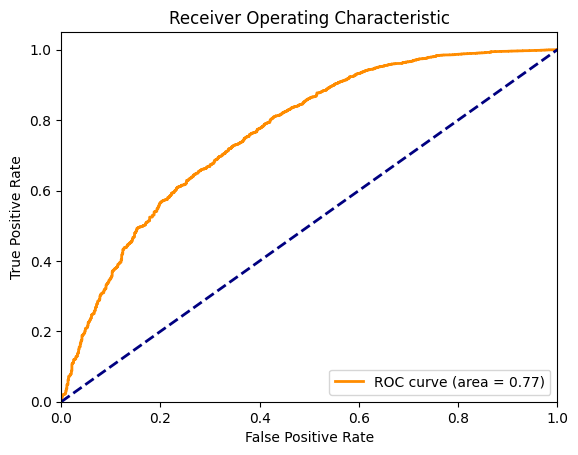

In [397]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

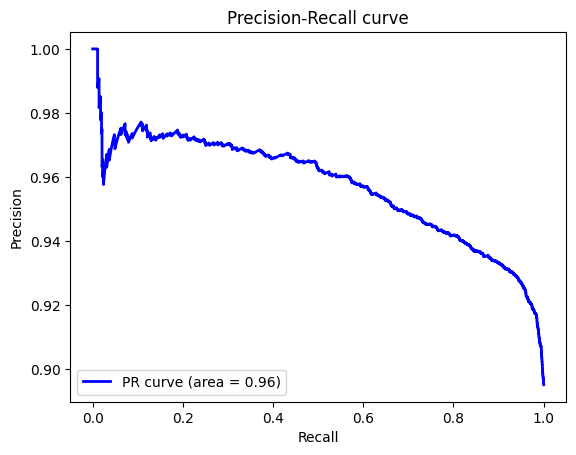

In [398]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()